<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../../Index.ipynb"><< Index</a>
<br>
<a href="./1_Load_and_visualize_data.ipynb"><< Load and visualise data</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./3_WQ_predict_image.ipynb" target="_blank">Water quality Prediction >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT), Ana Ruescas (Brockmann Consult GmbH / University of Valencia).

<div class="alert alert-block alert-success">
<h3>Liege Colloquium 2023</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>

The following modules are prerequisites for this notebook:
  - **<a href="./1_Load_and_visualize_data.ipynb">Load and visualise data</a>**
    
</div>
<hr>

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>

1. [Load data](#section1)
1. [Load models](#section2)
1. [Show errors](#section3)
1. [Boxplots](#section4)
1. [Permutation plots](#section5)
1. [Runtime plots](#section6)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import pandas as pd
import seaborn as sns
warnings.filterwarnings("ignore")

from ml import data_load_S3, models, ml_regression, Py4R_plots

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Load data
[Back to top](#TOC_TOP)

</div>

In [2]:
##Load the input data and split in training and test
data_X_train, data_X_test, data_y_train, data_y_test = data_load_S3.load_C2X()
mean_y_train = np.mean(data_y_train)

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Load models
[Back to top](#TOC_TOP)

</div>

In [3]:
##Load the all the models trained and stored in the 'models' folder
modelos = {}
table_preds = {}
for bands_name in data_load_S3.bands_try_C2X:
    for model in models.ALL_NAME_MODELS:
        file_model = os.path.join(data_load_S3.PATH_TO_MODELS_C2X,
                                  model+'_'+bands_name+'_CHL.pkl')
        if not os.path.exists(file_model):
            print("File %s does not exist"%file_model)
            continue
        
        print("Loading model & make test preds from file %s"%file_model)
        
        regressor_sklearn = joblib.load(file_model)
        modelos[model+"_"+bands_name] =regressor_sklearn 

        table_preds[model+"_"+bands_name] = regressor_sklearn.predict(data_X_test[data_load_S3.bands_try_C2X[bands_name]])+mean_y_train

table_preds = pd.DataFrame(table_preds)

Loading model & make test preds from file /Users/benloveday/Code/Git_Reps/CMTS/WEKEO/liege-colloquium-23/2_methodological_approaches/machine_learning/Machine_learning_regression_for_ocean_parameters_retrieval/ml/models/RLR_S3bands_CHL.pkl
Loading model & make test preds from file /Users/benloveday/Code/Git_Reps/CMTS/WEKEO/liege-colloquium-23/2_methodological_approaches/machine_learning/Machine_learning_regression_for_ocean_parameters_retrieval/ml/models/RFR_S3bands_CHL.pkl


In [4]:
##Visualize prediction by data points and models (test dataset)
table_preds

,RLR_S3bands,RFR_S3bands
0,6.189812,3.15165
1,2.998724,6.38525
2,0.396934,1.56685
3,-1.545665,3.58775
4,-0.488710,0.13765
...,...,...
5565,2.093250,2.49285
5566,1.846873,0.40530
5567,93.755927,194.32500
5568,1.301424,0.19435


<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Errors
[Back to top](#TOC_TOP)

</div>

In [5]:
##Load and define the metrics to be used
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
bands_ordered = ['S3bands']
datos = []

def pearson(y_true,y_pred):
    val,_ = pearsonr(y_true,y_pred)
    return val

def root_mean_squared_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def rmse_rel(y_true,y_pred):
    return np.sqrt(np.mean(((y_pred - y_true) / y_true) ** 2))

def bias(y_true,y_pred):
    return np.mean(y_pred - y_true)

   
metrics = [r2_score,bias, mean_absolute_error,pearson,
           root_mean_squared_error,rmse_rel ]

In [6]:
##Calculate metrics by dataset and model (training vs. test)
for b in bands_ordered:
    p = len(data_load_S3.bands_try_C2X[b])
    for m in models.ALL_NAME_MODELS:
        dato = {"model":m,"band":b}
        for metric in metrics:
            if m+"_"+b in table_preds:
                dato[metric.__name__] = metric(data_y_test,table_preds[m+"_"+b].values)
        
        n = data_X_train.shape[0]
        if "r2_score" in dato:
            dato["r2_adjusted"] = 1-(1-dato["r2_score"])*(n-1)/(n-p-1)
        
        if len(dato.keys())>2:
            datos.append(dato)
            
datos = pd.DataFrame(datos)  
datos.set_index(["band","model"])

r2_score          bias  mean_absolute_error   pearson   
band    model                                                          
S3bands RLR    0.636681  2.421203e-14             5.954289  0.797923  \
        RFR    0.963218 -1.391757e-02             1.433423  0.983167   

               root_mean_squared_error   rmse_rel  r2_adjusted  
band    model                                                   
S3bands RLR                  16.696014  11.279542     0.635700  
        RFR                   5.312335  10.001455     0.963119

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Boxplots (residuals)
[Back to top](#TOC_TOP)

</div>

In [7]:
##Residuals of the models to be plotted
table_residuals = table_preds.copy()

for c in table_preds.columns:
    table_residuals[c] = table_preds[c] - data_y_test

table_residuals = pd.melt(table_residuals,var_name="model_band")
table_residuals["model"] = table_residuals["model_band"].apply(lambda x: x.split("_")[0])
table_residuals["band"] = table_residuals["model_band"].apply(lambda x: "_".join(x.split("_")[1:]))

In [8]:
table_residuals=table_residuals.dropna()
table_residuals.head()

,model_band,value,model,band
0,RLR_S3bands,2.889812,RLR,S3bands
1,RLR_S3bands,-4.201276,RLR,S3bands
2,RLR_S3bands,-0.803066,RLR,S3bands
3,RLR_S3bands,-5.545665,RLR,S3bands
4,RLR_S3bands,-0.638710,RLR,S3bands


(-15.0, 15.0)

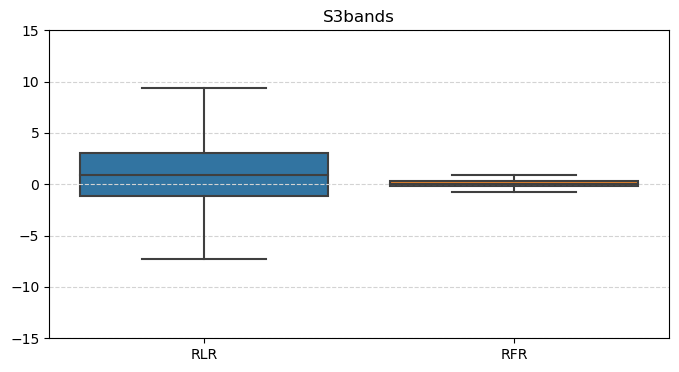

In [9]:
##Boxplot the residuals: the narrower the plot the better
fig,axs = plt.subplots(1,1,figsize=(8,4))
lab = "S3bands"
sns.boxplot(x="model",y="value",data=table_residuals[table_residuals["band"] == lab],
                order=[m for m in models.ALL_NAME_MODELS if m != "Polyfit"],ax=axs,fliersize=0)
axs.set_xlabel("")
axs.set_ylabel("")
axs.set_title(lab)
axs.yaxis.grid(color='lightgrey', linestyle='dashed')
axs.set_ylim(-15,15)

<div class="alert alert-info" role="alert">

## <a id='section5'></a>5. Permutation plots
[Back to top](#TOC_TOP)

</div>

In [10]:
##Numpy. random. permutation() function gives us the random samples of a sequence of permutation and returns sequence by using this method.
##Comparable methods are the RF feature importance or permutation_importance 
##https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

sal = []
for m in ['RLR', 'RFR']:#'KRR'
    for b in ["S3bands"]:
        model = m+"_"+b
        sal_ = Py4R_plots.permutation_test( modelos[model],
                                  data_X_test[data_load_S3.bands_try_C2X[b]], 
                                  data_y_test-mean_y_train)
        sal_["band"] = b
        sal_["model"] = m
        sal.append(sal_)

sal = pd.concat(sal,axis=0)
sal.head()

,variable,mean_absolute_error,band,model
0,400,54.447244,S3bands,RLR
1,400,54.534353,S3bands,RLR
2,400,54.999068,S3bands,RLR
3,400,54.808224,S3bands,RLR
4,400,54.124717,S3bands,RLR


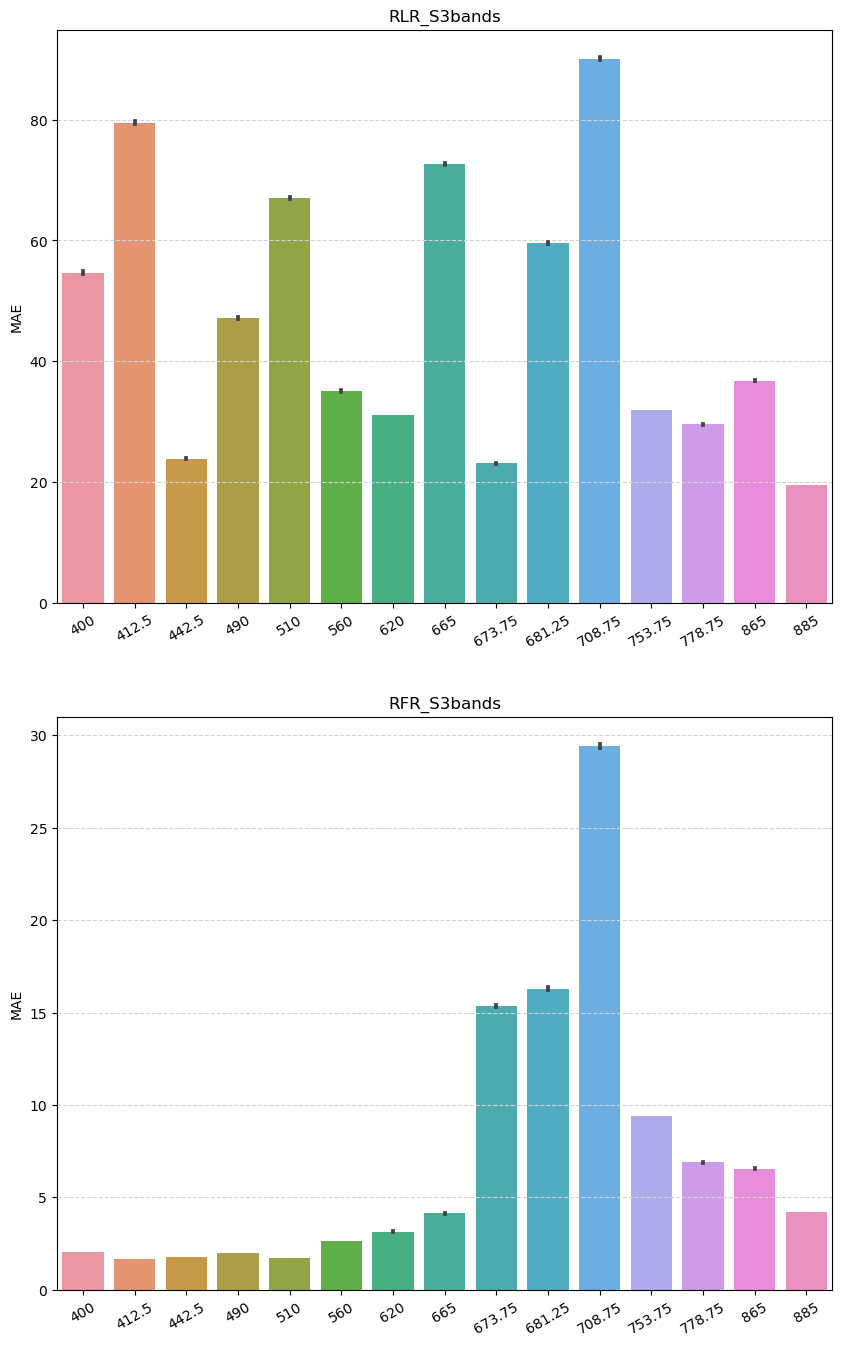

In [11]:
##Plotting the feature importance
fig,axs = plt.subplots(2,1,figsize=(10,20))
axs = axs.flatten()
for ax,model in zip(axs,[m+"_"+b for m in ['RLR', 'RFR'] for b in ["S3bands"]]):
    b = model.split("_")[1]
    m = model.split("_")[0]
    sns.barplot(x="variable", y="mean_absolute_error", data=sal[(sal["band"] == b) & (sal["model"] == m)],
                ax=ax)
    ax.yaxis.grid(color='lightgrey', linestyle='dashed')
    ax.patch.set_facecolor('white')
    ax.set_ylabel("MAE")
    ax.set_xlabel("")
    ax.set_title(model)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

plt.subplots_adjust(bottom=0.25)

<div class="alert alert-info" role="alert">

## <a id='section6'></a>6. Predicted vs measured plots
[Back to top](#TOC_TOP)

</div>

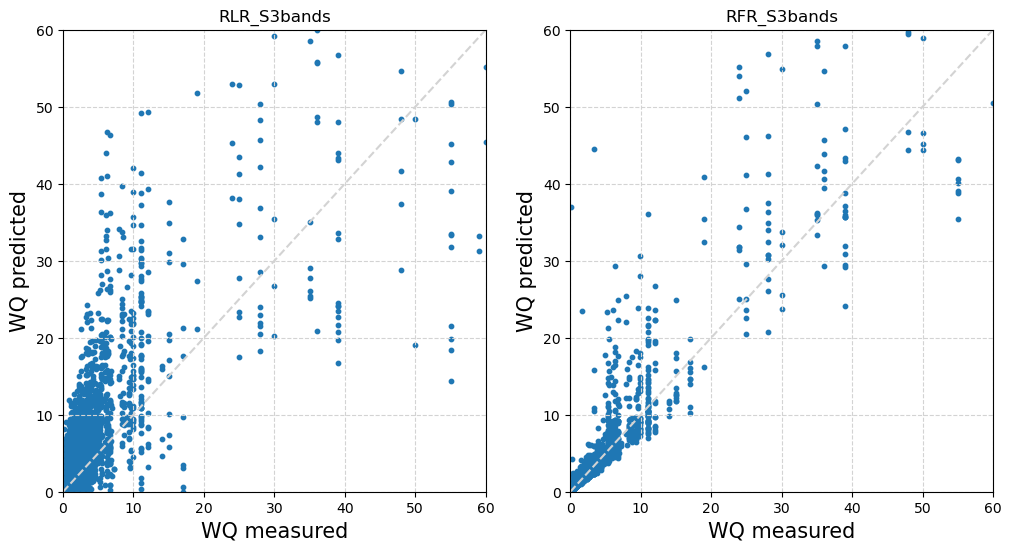

In [12]:
#from ml import Py4R_plots
##Generation of linear regression or scatter plots to compare measured vs. predicted values
fig,axs = plt.subplots(1,2,figsize=(12,6))

axs = axs.flatten()
for ax,model in zip(axs,["RLR_S3bands","RFR_S3bands"]):
    Py4R_plots.correlative_plot(table_preds[model],data_y_test,ax=ax)
    ax.set_title(model)

<hr>
<a href="../../Index.ipynb"><< Index</a>
<br>
<a href="./1_Load_and_visualize_data.ipynb"><< Load and visualise data</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./3_WQ_predict_image.ipynb" target="_blank">Water quality Prediction >></a>
<hr>
<a href="https://github.com/wekeo/liege-colloquium-23" target="_blank">View on GitHub</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>